### Import libraries to use

In [1]:
#import sys
#sys.path.append("/home/svanhmic/workspace/Python/Erhvervs/src/cvr")

SQLContext.newSession(sqlContext)

from pyspark.sql import functions as F
from pyspark.accumulators import AccumulatorParam
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StringType,StructField,StructType,ArrayType,DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT,Matrix,MatrixUDT,DenseMatrix
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row
from pyspark.sql import Window
from spark_sklearn import GridSearchCV,Converter
from sklearn.cluster import KMeans as skKmeans
from sklearn.linear_model import LogisticRegression as skLogistic
from pyspark.mllib.linalg import Vectors as oVector, VectorUDT as oVectorUDT


import pandas as pd
from IPython.display import display
import re
import random
from prettytable import PrettyTable
import sys
from datetime import datetime
from operator import add
import numpy as np
import matplotlib.pyplot as plt
#from spark_sklearn import GridSearchCV,Converter
PATH = "/home/svanhmic/workspace/Python/Erhvervs/data/cdata/"
sc.addPyFile("/home/svanhmic/workspace/Python/Erhvervs/src/cvr/GridSearchLogRegAndKmeans.py")

import GridSearchLogRegAndKmeans



/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Cleaned Data from cvr is imported, rank column name is changed to vaerdiSlope

In [2]:
#import data and rename bad name rank into vaerdiSlope
df = (sqlContext
      .read
      .parquet(PATH+"featureDataCvr")
     )

rankCols = [re.sub(pattern="rank_",repl="vaerdiSlope_",string=i) for i in df.columns ]
renamedDf = (df
             .withColumn(colName="reklamebeskyttet",col=F.col("reklamebeskyttet").cast("integer"))
             .select([F.col(val).alias(rankCols[idx]) for idx,val in enumerate(df.columns)])
            )
renamedDf.show()

+---------+--------------------+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+-----------+-----------------+------------------+------------------+------------------+------------------+-------------+-------------+-------------+-------------+----------------+---------------+
|cvrNummer|              status|label|AarsVaerk_1|AarsVaerk_2|AarsVaerk_3|AarsVaerk_4|AarsVaerk_5|AarsVaerk_6|AarsVaerk_7|AarsVaerk_8|AarsVaerk_9|AarsVaerk_10|AarsVaerk_11|AarsVaerk_12|AarsVaerk_13|AarsVaerk_14|AarsVaerk_15|medArb_1|medArb_2|medArb_3|medArb_4|medArb_5|medArb_6|medArb_7|medArb_8|medArb_9|medArb_10|medArb_11|medArb_12|medArb_13|medArb_14|medArb_15|avgVarighed|totalAabneEnheder|totalLukketEnheder|     vaerdiSlope_1|     v

In [3]:
def getAllDistances(matrix1,matrix2):
    return [[np.linalg.norm(v-w) for v in matrix1 ] for w in matrix2]

def createPrettyTable(matrix,labels,names=None):
    #print(type(matrix))
    try:
        x = PrettyTable(["v"]+labels)
    except:
        x = PrettyTable(["v"]+list(labels))
    if names is not None:
        zippedMatrix = zip(names,matrix)
    else:
        zippedMatrix = enumerate(matrix)
    
    
    for  i in labels:
        x.align[str(i)] = "l"
    for idx,v in zippedMatrix:
        #print(type(v))
        x.add_row([str(idx)]+['{:.7}'.format(str(i)) for i in v])
    return x

In [5]:
#import name data frame

windowSpecRank =(Window.partitionBy(F.col("cvrNummer"))).orderBy(F.col("periode_gyldigFra").desc())

groupCols = ["cvrNummer","vaerdi"]

companyNameDf = (sqlContext
                 .read
                 .parquet(PATH+"companyCvrData")
                 .withColumn(colName="rank",col=F.rank().over(windowSpecRank))
                 .filter((F.col("rank")==1) & (F.col("sekvensnr")==0))
                 .select([F.col(i) for i in groupCols])
                 .withColumnRenamed(existing="vaerdi",new="navn")
                 .orderBy(F.col("cvrNummer"))
                 .cache()
                )
#companyNameDf.show()


In [5]:
#take ln(x+1) of features
#Depricated!
labelCols = ["navn","cvrNummer","label","status"]
featCols = [i for i in companyNameDf.columns+renamedDf.columns if i not in labelCols]

minCols = [F.min(i).alias(i) for i in featCols]
minValsRdd = renamedDf.groupby().agg(*minCols).rdd
broadcastedmin = sc.broadcast(minValsRdd.first().asDict())

logColsSelected = [F.col(i).alias(i) for i in labelCols]+[(F.col(i)-F.lit(broadcastedmin.value[i])).alias(i) for i in featCols]
logDf = (renamedDf
         .join(companyNameDf,(companyNameDf["cvrNummer"]==renamedDf["cvrNummer"]),"inner")
         .drop(companyNameDf["cvrNummer"])
         .select(*logColsSelected)
         .select([F.col(i).alias(i) for i in labelCols]+[F.log1p(F.col(i)).alias(i) for i in featCols])
         .distinct()
         .na
         .fill(0.0,featCols) # yes i know we set null to zero here. But a company has zero in kapital if it is not opened
         .cache()
        )

In [6]:
#First convert features to vetor and scale it with mean and stddev
toDenseUDf = F.udf(lambda x: Vectors.dense(x.toArray()),VectorUDT())
vectorizer = VectorAssembler(inputCols=featCols,outputCol="features")

rawVectorDataDf = (vectorizer.transform(renamedDf                                                                               
                                        .join(companyNameDf,(companyNameDf["cvrNummer"]==renamedDf["cvrNummer"]),"inner")
                                        .drop(companyNameDf["cvrNummer"]) 
                                        .na
                                        .fill(0.0,featCols)
                                        .distinct()
                                       )
                   .select(labelCols+[toDenseUDf(vectorizer.getOutputCol()).alias(vectorizer.getOutputCol())])
                  )

standardScale = StandardScaler(withMean=True,withStd=True,inputCol=vectorizer.getOutputCol(),outputCol="scaledFeatures")
standardScaleModel = standardScale.fit(rawVectorDataDf)
scaledFeaturesDf = (standardScaleModel
                    .transform(rawVectorDataDf)
                    .drop("features")
                    .withColumnRenamed(existing="scaledFeatures",new="features")
                    .filter(F.col("label") != 2)
                   )
scaledFeaturesDf.show()

+--------------------+---------+-----+--------------------+--------------------+
|                navn|cvrNummer|label|              status|            features|
+--------------------+---------+-----+--------------------+--------------------+
|   EMPAKA KARTONNAGE| 10016533|    1|            [NORMAL]|[0.12721405809989...|
|      DET GAMLE GODS| 10016606|    1|            [NORMAL]|[-0.1483813281958...|
|               DIXEN| 10018064|    0|[OPLØST EFTER KON...|[-0.1483813281958...|
|        TRELBORG VVS| 10063760|    1|            [NORMAL]|[-0.1483813281958...|
|            CYBERSUN| 10065917|    0|[OPLØST EFTER KON...|[-0.0258944898421...|
|                HME2| 10080207|    1|            [NORMAL]|[-0.1483813281958...|
|TØMRERFIRMAET HER...| 10082528|    1|            [NORMAL]|[-0.1177596186074...|
|    MØRKHOLT VINDUER| 10096227|    1|            [NORMAL]|[-0.1483813281958...|
|                KISØ| 10108993|    1|            [NORMAL]|[-0.1177596186074...|
|               C-CUT| 10117

In [7]:
#show new summery statistics
stats = [standardScaleModel.mean,standardScaleModel.std]
statsShow = createPrettyTable(matrix=stats,labels=featCols,names=["mean","std"])
print(statsShow)

+------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-------------------+--------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------------------+
|  v   | AarsVaerk_1 | AarsVaerk_2 | AarsVaerk_3 | AarsVaerk_4 | AarsVaerk_5 | AarsVaerk_6 | AarsVaerk_7 | AarsVaerk_8 | AarsVaerk_9 | AarsVaerk_10 | AarsVaerk_11 | AarsVaerk_12 | AarsVaerk_13 | AarsVaerk_14 | AarsVaerk_15 | medArb_1 | medArb_2 | medArb_3 | medArb_4 | medArb_5 | medArb_6 | medArb_7 | medArb_8 | medArb_9 | medArb_10 | medArb_11 | medArb_12 | medArb_13 | medArb_14 | medArb_15 | avgVarighed | totalAab

In [8]:
#dfDescriptionDf = renamedDf.describe()

In [9]:
def printDf(df):
    #this method is very narrow aimed towards this particular problem.
    ##TODO: create a general method for printing summery statistics. 
    df.select([F.col("summary")]+[F.col("AarsVaerk_"+str(i)) for i in range(1,6)]).show()
    df.select([F.col("summary")]+[F.col("AarsVaerk_"+str(i)) for i in range(6,11)]).show()
    df.select([F.col("summary")]+[F.col("AarsVaerk_"+str(i)) for i in range(10,16)]).show()
    df.select([F.col("summary")]+[F.col("medArb_"+str(i)) for i in range(1,7)]).show()
    df.select([F.col("summary")]+[F.col("medArb_"+str(i)) for i in range(7,12)]).show()
    df.select([F.col("summary")]+[F.col("medArb_"+str(i)) for i in range(11,16)]).show()
    df.select([F.col("summary")]+[F.col("vaerdiSlope_"+str(i)) for i in range(1,6)]).show()
    df.select([F.col("summary")]+[F.col("vaerdiSlope_"+str(i)) for i in range(6,8)]).show()
    cols = ["avgVarighed","totalAabneEnheder","totalLukketEnheder","reklamebeskyttet"]
    df.select([F.col("summary")]+[F.col(i) for i in cols]).show()


Initial analysis completed now it's time for using machine learning!

In [10]:
def getConfusion(label,prediction,outlier):
    diff = abs(label-prediction)
    if (diff == 0) and (label == 0):
        return "TN"
    elif (diff == 0) and (label == 1):
        return "TP"
    elif (diff == 1) and (label == 0):
        return "FP"
    elif (diff == 1) and (label == 1):
        return "FN"
    elif outlier > 0:
        return "Excluded"

subUdf = F.udf(lambda x,y,z: getConfusion(x,y,z),StringType())


def computeConfusion(df):
    cols = [F.col(i) for i in ("cvrNummer","label","predictionLogReg")]
    return (df
            .select(*cols,subUdf(df["label"],df["predictionLogReg"],df["isOutlier"]).alias("diff"))
            .groupby().pivot("diff",["TP","TN","FN","FP","Excluded"])
            .count()
            .withColumn(col=(F.col("TP")+F.col("TN"))/(F.col("TP")+F.col("TN")+F.col("FN")+F.col("FP")),colName="Accuracy")
           )


def showStats(df):
    accuracyDf = computeConfusion(df)
    accuracyDf.show()

In [11]:

def runner(df,**kvargs):
    '''
        This method computes the accuracy for each of iteration of the combined k-means logistic regression method. 
        It outputs a spark dataframe that has been subjected to the iterations and contains clusters that have been
        segmented into k clusters, and has been 
    '''
    if "isOutlier" not in df.columns: 
        df = df.withColumn(colName="isOutlier",col=F.lit(0))
    dfs = GridSearchLogRegAndKmeans.createPandasDf(sc,df,"features","cvrNummer","label","isOutlier")
    iteration = kvargs.get("i",2)
    labelCol = kvargs.get("labelCol","label")
    idCol = kvargs.get("idCol","cvrNummer")
    featuresCol = kvargs.get("featuresCol","features")
    threshold = kvargs.get("threshold",0.005)
    dfsI = dfs
    
    
    for i in range(1,iteration):
        dfsI = (GridSearchLogRegAndKmeans
                                       .onePass(sc,dfsI,{'n_clusters':(8,10),},featuresCol,idCol,labelCol,i,threshold)
                                      )
        #display(trainPdf)
        #display(testPdf)
        #display(OutlierPdf)
        sparkDf = sqlContext.createDataFrame(dfsI)
        if i == 1:
            totalDf = (computeConfusion(sparkDf)
                       .withColumn(col=F.lit(i),colName="iteration") 
                      )
        else:
            totalDf = (totalDf
                       .unionAll(computeConfusion(sparkDf).withColumn(col=F.lit(i),colName="iteration"))
                      )
    return (sparkDf,totalDf)


In [12]:
#print(dfs)

segmentedDf,statsDf = runner(scaledFeaturesDf,i=5)



no extra cols
Index(['cvrNummer', 'features', 'label', 'isOutlier'], dtype='object')
Remaining data points: 127527
Total data points: 159771
Excluded data points: 362
Remaining data points: 126883
Total data points: 159409
Excluded data points: 1167
Remaining data points: 126459
Total data points: 158604
Excluded data points: 1697
Remaining data points: 126444
Total data points: 158074
Excluded data points: 1715


In [13]:
statsDf.show()

+-----+---+---+----+--------+------------------+---------+
|   TP| TN| FN|  FP|Excluded|          Accuracy|iteration|
+-----+---+---+----+--------+------------------+---------+
|25703| 96| 73|6010|     362|0.8092026849005709|        1|
|25519|149|107|5946|    1167|0.8091800384603259|        2|
|25379|204|150|5882|    1697|0.8092044915388265|        3|
|25378|199|148|5887|    1715|0.8090914842464887|        4|
+-----+---+---+----+--------+------------------+---------+



In [14]:
segmentedDf.show()

+---------+--------------------+---------+-----+----------------+----------------+
|cvrNummer|            features|isOutlier|label|predictionKmeans|predictionLogReg|
+---------+--------------------+---------+-----+----------------+----------------+
| 10016533|[0.12721405809989...|        0|    1|             1.0|             1.0|
| 10016606|[-0.1483813281958...|        0|    1|             2.0|             1.0|
| 10018064|[-0.1483813281958...|        0|    0|             7.0|             1.0|
| 10063760|[-0.1483813281958...|        0|    1|             8.0|             1.0|
| 10065917|[-0.0258944898421...|        0|    0|             0.0|             1.0|
| 10080207|[-0.1483813281958...|        0|    1|             8.0|             1.0|
| 10082528|[-0.1177596186074...|        0|    1|             8.0|             1.0|
| 10096227|[-0.1483813281958...|        0|    1|             8.0|             1.0|
| 10108993|[-0.1177596186074...|        0|    1|             8.0|             1.0|
| 10

In [4]:
vec = [Row(cluster=i,center=Vectors.dense(v)) for i,v in enumerate(bModel.clusterCenters())]
#print(type(vec))
SpDf = sqlContext.createDataFrame(data=vec)
#SpDf.show(truncate=False)

#compute the squared distance beetween the cluster-center and its data points.

featureContributionUdf = F.udf(lambda x,y: (x-y)*(x-y),VectorUDT() )
sqrtUdf = F.udf(lambda x,y: float(Vectors.norm(vector=x-y,p=2)),DoubleType())
printUdf = F.udf(lambda x: type(x),StringType())
#print(np.sum(vec[0]["vec"]))
joinedDf = (predictDf
            .withColumn(colName="features",col=toDenseUDf(F.col("features")))
            .join(SpDf,on=(predictDf["prediction"]==SpDf["cluster"]),how="left")
            .drop(SpDf["cluster"])
            .withColumn(colName="contribution",col=featureContributionUdf(F.col("features"),F.col("center")))
            .withColumn(colName="distance",col=sqrtUdf(F.col("features"),F.col("center")))
            .drop("centers")
            .drop("features")
            
            .orderBy(F.col("distance").desc())
           )

joinedDf.show(truncate=True)
#joinedDf.printSchema()

NameError: name 'bModel' is not defined

In [2]:
joinedDf.groupBy("label").count()

NameError: name 'joinedDf' is not defined

In [112]:
#show elements in joinedDf
#joinedDf.filter(F.col("prediction")==7).show(truncate=True)

#windowDistToAll  = (Window.partitionBy(F.col("prediction")))

class VectorAccumulatorParam(AccumulatorParam):
    def zero(self, value):
        return [0.0] * len(value)
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1
    
va = sc.accumulator([1.0, 2.0, 3.0], VectorAccumulatorParam())
va.value
def g(x):
    global va
    va += [x] * 3
rdd.foreach(g)
va.value



AttributeError: 'tuple' object has no attribute 'take'

In [32]:
centroids = bModel.clusterCenters()

cols = ["prediction","label"]
funcs = [F.count, F.sum]
funcCols = [f(i) for f in funcs for i in cols]
#list the number of elements in each cluster
groupedByClusters = (joinedDf
                     .filter(F.col("label") <= 1)
                     .groupBy(F.col("prediction"))
                     .agg(*funcCols)
                     .drop(F.col("sum(prediction)"))
                     .drop(F.col("count(label)"))
                     .withColumn(colName="bancruptcy ratio",col=F.col("sum(label)")/F.col("count(prediction)"))
                    )
groupedByClusters.show()

#show distances for all cluster centers
allDists = getAllDistances(centroids,centroids)
pred = createPrettyTable(allDists,range(0,len(allDists)))
print(pred)

+----------+-----------------+----------+------------------+
|prediction|count(prediction)|sum(label)|  bancruptcy ratio|
+----------+-----------------+----------+------------------+
|         1|               68|        68|               1.0|
|         6|                2|         2|               1.0|
|         3|                1|         1|               1.0|
|         5|            12753|     12130|0.9511487493138869|
|         9|              186|       176| 0.946236559139785|
|         4|                1|         1|               1.0|
|         8|            22407|     18118|0.8085866024010354|
|         7|                8|         8|               1.0|
|         2|             1243|      1172|0.9428801287208367|
|         0|           123102|     97552|0.7924485386102582|
+----------+-----------------+----------+------------------+

+---+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
| v | 0       | 1       | 2       | 3  

In [48]:
#take out cluster two 



clusterTwo = (joinedDf
              .filter((F.col("prediction") == 6) | 
                      (F.col("prediction") == 1) | 
                      (F.col("prediction") == 4) | 
                      (F.col("prediction") == 3) | 
                      (F.col("prediction") == 7) |
                      (F.col("prediction") == 9))
              .drop(F.col("center"))
              .orderBy(F.col("prediction").desc(),F.col("distance").desc())
             )
clusterTwo.show(300,truncate=True)



+--------------------+---------+-----+--------------------+----------+--------------------+------------------+
|                navn|cvrNummer|label|              status|prediction|        contribution|          distance|
+--------------------+---------+-----+--------------------+----------+--------------------+------------------+
| AAK DENMARK HOLDING| 45954919|    1|            [NORMAL]|         9|[175.272675248476...| 262.0141663914305|
|        COOP TRADING| 20406194|    1|            [NORMAL]|         9|[144.340768947889...|107.36946714293636|
|       GROUP 4 FALCK| 24792110|    1|[OPLØST EFTER SPA...|         9|[144.340768947889...|104.31912237790463|
|  TDC TOTALLØSNINGER| 25767535|    1|[OPLØST EFTER FUS...|         9|[291.604591088187...|101.49116950212107|
|               NETTO| 24603717|    1|[OPLØST EFTER FUS...|         9|[291.604591088187...| 97.54914169205776|
|      BIOMAR HOLDING| 41951818|    1|[OPLØST EFTER FUS...|         9|[179.350143583126...| 97.18591338425341|
|

In [34]:
def printTotalAndAvgFeatContribution(df,cluster=0,toPrint=False):
    avgFeatureContributionRDD = (df
                                 .filter(F.col("prediction") == cluster)
                                 .select("cvrNummer","navn","contribution")
                                 .rdd)
    
    length = len(avgFeatureContributionRDD.first()["contribution"])

    totalContribution = avgFeatureContributionRDD.map(lambda x: x[2]).reduce(add)
    avgContribution = totalContribution/avgFeatureContributionRDD.count()
    columns = [totalContribution.toArray(),avgContribution.toArray(),]
    contributions = createPrettyTable(columns,featCols,["total","avg"])
    if toPrint:
        print(contributions)
    return avgContribution

In [35]:
cluster6 = printTotalAndAvgFeatContribution(joinedDf,6)

In [36]:
cluster1 = printTotalAndAvgFeatContribution(joinedDf,1)

In [37]:
cluster8 = printTotalAndAvgFeatContribution(joinedDf,8)

In [38]:
cluster0 = printTotalAndAvgFeatContribution(joinedDf,0)

In [39]:
cluster2 = printTotalAndAvgFeatContribution(joinedDf,2)
cluster3 = printTotalAndAvgFeatContribution(joinedDf,3)
cluster4 = printTotalAndAvgFeatContribution(joinedDf,4)
cluster5 = printTotalAndAvgFeatContribution(joinedDf,5)
cluster7 = printTotalAndAvgFeatContribution(joinedDf,7)
cluster9 = printTotalAndAvgFeatContribution(joinedDf,9)

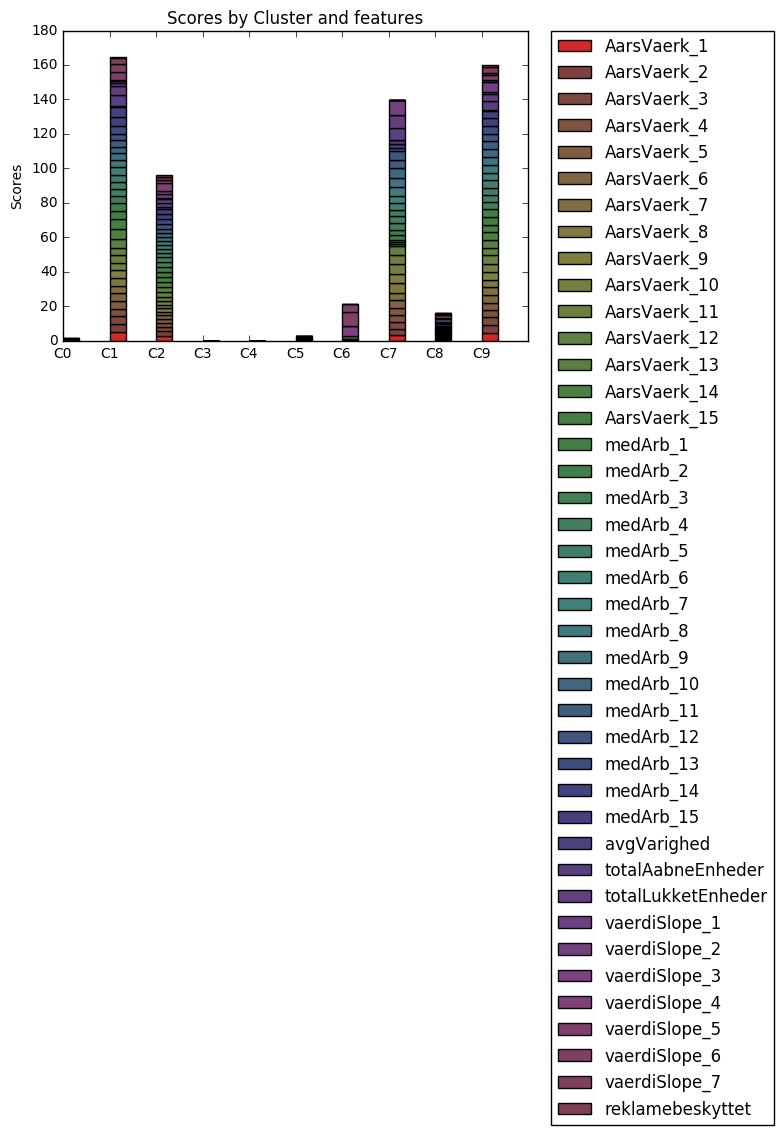

In [40]:
clusters = np.array([cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9])
transposedCluster = np.log1p(clusters.transpose())
N = 10

import colorsys
HSV_tuples = [(x*1.0/len(transposedCluster), 0.5, 0.5) for x in range(len(transposedCluster))]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

ind = np.arange(N)    # the x locations for the groups
width = 0.35 
plots = [plt.bar(ind, transposedCluster[1], width, color='#d62728')]  
former = transposedCluster[1]
for i,v in enumerate(transposedCluster[1:]):
    plots.append(plt.bar(ind, v, width, color=RGB_tuples[i],bottom=former))
    former += v
plt.ylabel('Scores')
plt.title('Scores by Cluster and features')
plt.xticks(ind, ('C0', 'C1','C2','C3','C4','C5', 'C6','C7', 'C8','C9'))
plt.legend([p[0] for p in plots], featCols,bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)
plt.show()

In [ ]:
#how does it look in each of the clusters 
